![Practicum AI Logo image](https://github.com/PracticumAI/practicumai.github.io/blob/main/images/logo/PracticumAI_logo_250x50.png?raw=true) <img src='https://github.com/PracticumAI/deep_learning/blob/main/images/practicumai_deep_learning.png?raw=true' alt='Practicum AI: Deep Learning Foundations icon' align='right' width=50>
***

# Managing Class Imbalance in Data

Kevin now understands CNNs and how they work, but his model is still not performing as well as he would like. He's been reading up on some techniques to improve his model's performance and is excited to try them out. 

In this notebook, we will explore two methods to help mitigate the issues that class imbalance poses: stratification and class weighting.

* **Stratification:** Ensures that class frequencies are maintained when making the training and validation datasets. In extreme cases, minority classes can be totally absent from a sampled dataset. But even in the case of less extreme imbalances and larger datasets, stratification can ensure class distributions are the same and help the model train.

* **Class weighting:** By default, the probability of any class is assumed to be equal when training a model. In the case of imbalanced classes, that can cause an issue. We can calculate per-class probabilities and use the class weights when training the model.


One particularly good article on this is topic is Ayush Thakur and Aritra Roy Gosthipaty's article [Simple Ways to Tackle Class Imbalance](https://wandb.ai/authors/class-imbalance/reports/Simple-Ways-to-Tackle-Class-Imbalance--VmlldzoxODA3NTk) (Thakur & Gosthipaty). While we won't cover all the methods outlined, it's a good resource.

## A note about class imbalance and the bees vs wasp dataset

One important point out is that class imbalance can arise from several causes. In the case with our bee and wasp data, the fundamental issue is more of a data quality and collection issue. The real answer to solving the problem has more to do with rethinking the data:

* Do the categories rally make sense? Probably not--the non-insect category is not really helpful in this case and probably causes more issues than it solves. 
* Can better data solve the problem? Most likely--we can get more images of bees and other insects.
* Are the images quality images? In many cases, not--many images would be impossible for a human to identify! We must trust the labels.

Data quality is critical, though not something we will tackle here. Our hyperparameter tuning, stratification, and using class weights will only do so much to improve the results.

But, in many cases, class imbalance is an intrinsic part of the data. Rare diseases are a classic example of this. If a disease has an incidence of only 1%, training data for that class will be limited. In these cases, the tools we will cover may be more critical.


## 1. Import the libraries we will use

In [1]:
import tensorflow as tf   # Import the TensorFlow library, which provides tools for deep learning.
import pandas as pd  # Import the pandas library, used for data manipulation and analysis.
from sklearn.model_selection import train_test_split
import datetime

# Used for data management
import requests
import os
import time
import tarfile

import matplotlib.pyplot as plt  # Import the matplotlib library for plotting and visualization.
# This line allows for the display of plots directly within the Jupyter notebook interface.
%matplotlib inline  
 
# Import Keras libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Import the ImageDataGenerator class from Keras module in TensorFlow.
from tensorflow.keras.models import Sequential  # Import the Sequential model: a linear stack of layers from Keras module in TensorFlow.
from tensorflow.keras.layers import Dense  # Import the Dense layer: a fully connected neural network layer from Keras module in TensorFlow.
from tensorflow.keras.layers import Flatten  # Import the Flatten layer: used to convert input data into a 1D array from Keras module in TensorFlow.
from tensorflow.keras.losses import SparseCategoricalCrossentropy  # Import the SparseCategoricalCrossentropy loss function from Keras module in TensorFlow.
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers 
from tensorflow.keras import losses
from sklearn.metrics import confusion_matrix 
import numpy as np 

from sklearn.utils import class_weight

# Import helper functions--most of these were in the cells of the DLF_03_bees_vs_wasps.ipynb notebook.
# We moved them out of the notebook to enhace readability. 
import helpers_01_2

# Load the TensorBoard notebook extension
%load_ext tensorboard

2024-07-08 19:03:40.081790: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-08 19:03:40.081841: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-08 19:03:40.145715: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-08 19:03:40.228987: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2. Exploring the data

As before we'll use our helper function `helpers_01.manage_data` to make sure we have the data and set the `data_path`.

In the last notebook, Kevin noticed that his model had a big problem: it thought everything was wasps! Let's explore the data a bit and see if we can figure out why.

First let's make a histogram of the number of images in each class. That should give us a good idea of how balanced the dataset is.

In [2]:
# Chech for the data.
data_path = helpers_01.manage_data() 

Found data at /blue/practicum-ai/share/data/bee_vs_wasp.


Category wasp: 4,943 images, or 43.3% of total images.
Category bee: 3,184 images, or 27.9% of total images.
Category other_insect: 2,439 images, or 21.4% of total images.
Category other_noinsect: 856 images, or 7.5% of total images.
************************************


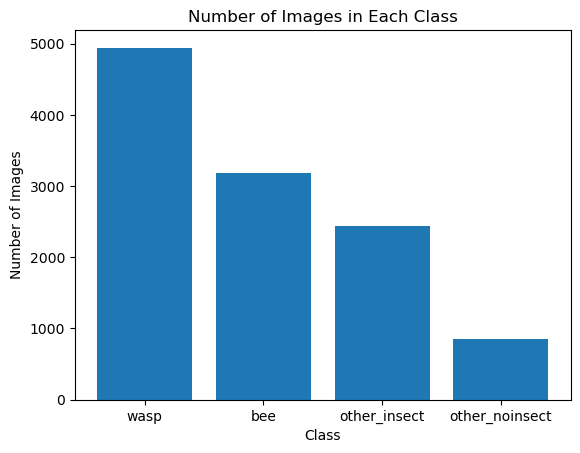

In [3]:
# Make a histogram of the number of images in each class
def make_hist_get_max(data_path):
    # Get the class names
    class_names = os.listdir(data_path)

    # Initialize an empty list to store the number of images in each class
    num_images = []

    # Loop through each class
    for class_name in class_names:
        # Get the list of images in the class
        images = os.listdir(os.path.join(data_path, class_name))
        # Append the number of images in the class to the list
        num_images.append(len(images))

    # Put the number of images in each class in descending order
    num_images, class_names = zip(*sorted(zip(num_images, class_names), reverse=True))

    total_images = sum(num_images)
    
    # Print the number of images in each class
    for i in range(len(class_names)):
        percentage = (num_images[i] / total_images) * 100
        print(f'Category {class_names[i]}: {num_images[i]:,} images, or {percentage:.1f}% of total images.')

    print("************************************")       
        
    # Create a histogram of the number of images in each class
    plt.bar(class_names, num_images)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Number of Images in Each Class')
    plt.show()

    return num_images

num_images = make_hist_get_max(data_path)

Yikes! That's a pretty big class imbalance--there are almost 5,000 wasp images and less than 1,000 other non-insect images. Large class imbalances tend to make models biased towards the majority class. This is likely why Kevin's model was predicting everything as wasps. Let's try to fix this!

Part of the issue with imballanced data is that the algorithm can do fairly well by never predicting the rare class(es).

As an example, let's imaging we are looking at a rare disease. If only 5% of the data are from the disease state, a model can be 95% accurate by never predicting disease. That 95% accuracy sounds good, but the model is not too helpful!

## 3. Stratification

The first method we will implement is stratification. Again, stratification ensures that when our dataset is split into training and validation sets, the class frequencies match the frequencies of the original data. This may not seem like a big issue with our dataset, but as we will see, it does help a lot! Ensuring that training and validation class frequencies are the same is important.

Let's try this out. We'll use the `train_test_split` function from `sklearn` to split the data into training and validation sets. We'll set the `stratify` parameter to the labels so that the function samples in a stratified manner.

We'll use a slightly modified version of the `load_display_data` function we used in the first notebook. It is now in the [`helpers_01`](helpers_01.py) module we imported. We will pass `show_pictures=False` to skip that.

You can look in the [`helpers_01`](helpers_01.py) file for the full code, but the code for stratifying is here:

```python
 if stratify: # Use sklearn's train_test_split function to split the data 
                 # into training and testing sets
        # Split the data in a stratified manner
        X_train, X_val, y_train, y_val = train_test_split(images, labels, 
                                test_size=0.2, stratify=labels)
```


In [11]:
# Create a function that loads data for an object detection model
def load_display_data(path, batch_size=32, shape=(80,80,3), show_pictures=True,
                      stratify=True, return_cls_counts=False):
    '''Takes info on how to load and process images.
       Returns training and testing datasets. 
       If retern_cls_counts=True, this is also returned as 3rd value.
    '''
    print("***********************************************************************")
    print("Load data:")
    print(f"  - Loading the dataset from: {path}.")
    print(f"  - Using a batch size of: {batch_size}.")
    print(f"  - Resizing input images to: {shape}.")
    print(f"  - Stratify when sampling? {stratify}")
    print(f"  - Returning class counts to calculate wieghts? {return_cls_counts}")
    print("***********************************************************************")
    
    batch_size = batch_size  # Define the batch size
    
    # Define the image size using the 1st 2 elements of the shape parameter
    # We don't need the number of channels here, just the dimensions to use
    image_size = shape[:2]

    # Get the class names
    class_names = os.listdir(path)

    images = [] # Initialize the images list
    labels = [] # Initialize the labels list
    cls_counts={}
          
    # Get the images and labels to use for training and validation
    for class_name in class_names:
        class_path = os.path.join(path, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            images.append(image_path)
            labels.append(class_name)

    # Print the number of number of images per class
    print("\nFor the full dataset:")
    for class_name in class_names:
        print(f'Number of {class_name} images: {labels.count(class_name)}, or {labels.count(class_name)/len(labels)*100:.1f}%')
        # Save class count to return if requested
        cls_counts[class_name]=labels.count(class_name)
        
    # We originally used the image_dataset_from_directory function. That
    # doesn't suppot stratification. So, we're changing to use a dataframe
    # and an ImageDataGenerator.
          
    if stratify: # Use sklearn's train_test_split function to split the data 
                 # into training and testing sets
        # Split the data in a stratified manner
        X_train, X_val, y_train, y_val = train_test_split(images, labels, 
                                test_size=0.2, stratify=labels)
    else:
        # Split the data randomly
        X_train, X_val = train_test_split(images, test_size=0.2)

    # Build the DataFrames for the training and validation sets
    train_df = pd.DataFrame(list(zip(X_train, y_train)), columns=['image', 'class'])
    val_df = pd.DataFrame(list(zip(X_val, y_val)), columns=['image', 'class'])
    

    # Define the ImageDataGenerator class with rescaling for each channel
    # Normalizing the data is a good 1st step
    train_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    # Define the training and validation data generators
    # Note that the training/validation split was already done above,
    # so, we are not using the validation_split here.
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='image',
        y_col='class',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)
    
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='image',
        y_col='class',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)


    if show_pictures:
        # Get the class names
        class_names = list(train_generator.class_indices.keys())
        print(class_names)

        # Display up to 3 images from each of the categories
        for i, class_name in enumerate(class_names):
            plt.figure(figsize=(10, 10))
            
            # Get a single batch to use for display
            images, labels = train_generator.next()

            # Un-normalize the images for display
            images = images * 255

            # Filter images of the current class
            class_images = images[labels[:, i] == 1]
                
            # Number of images to show. We don't want to show more than 3 images.
            num_images = min(len(class_images), 3)
                
            for j in range(num_images):
                ax = plt.subplot(1, num_images, j + 1)
                plt.imshow(class_images[j].astype("uint8"))
                plt.title(class_name)
                plt.axis("off")
            plt.show()
    
    print("\nFor the training dataset:")         
    for class_name  in class_names:
        count = y_train.count(class_name)
        print(f'Number of {class_name} images: {count}, or {count/len(y_train)*100:.1f}%')

    if return_cls_counts:
        print(f"\nClass counts being returned: {cls_counts}.")
        return train_generator, val_generator, cls_counts
    else:
        return train_generator, val_generator

X_train, X_valid = load_display_data(data_path, batch_size=32, shape=(80,80,3), show_pictures=False, stratify=True)

***********************************************************************
Load data:
  - Loading the dataset from: /blue/practicum-ai/share/data/bee_vs_wasp.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
  - Stratify when sampling? True
  - Returning class counts to calculate wieghts? False
***********************************************************************

For the full dataset:
Number of wasp images: 4943, or 43.3%
Number of other_insect images: 2439, or 21.4%
Number of bee images: 3184, or 27.9%
Number of other_noinsect images: 856, or 7.5%
Found 9137 validated image filenames belonging to 4 classes.
Found 2284 validated image filenames belonging to 4 classes.

For the training dataset:
Number of wasp images: 3954, or 43.3%
Number of other_insect images: 1951, or 21.4%
Number of bee images: 2547, or 27.9%
Number of other_noinsect images: 685, or 7.5%


/apps/tensorflow/2.15/lib/python3.11/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


In [13]:
def make_model(activation='relu', shape=(80,80,3), num_classes=4):
    '''Sets up a model. 
          Takes in an activation function, shape for the input images, and number of classes.
          Returns the model.'''
    print("***********************************************************************")
    print("Make model:")
    print(f"  - Using the activation function: {activation}.")
    print(f"  - Model will have {num_classes} classes.")
    print("***********************************************************************")
    
    # Define the model
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', activation=activation, input_shape=shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), padding='same', activation=activation),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        layers.Conv2D(128, (3, 3), padding='same', activation=activation),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation=activation),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

model = make_model()
model.summary()

***********************************************************************
Make model:
  - Using the activation function: relu.
  - Model will have 4 classes.
***********************************************************************
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 80, 80, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 40, 40, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 40, 40, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 20, 20, 64)        0         
 g2D)                                                            
                        

In [7]:
# Define a function that takes an optimizer name as a string
def load_optimizer(optimizer_name):
  # Check if the optimizer name is valid
  if optimizer_name in tf.keras.optimizers.__dict__:
    # Return the corresponding optimizer function
    return tf.keras.optimizers.__dict__[optimizer_name]
  else:
    # Raise an exception if the optimizer name is invalid
    raise ValueError(f"Invalid optimizer name: {optimizer_name}")

def compile_train_model(train_set, val_set, model,
                        loss='categorical_crossentropy',
                        optimizer='Adam', learning_rate=0.0001, epochs=10):
    '''Compiles and trains the model. 
          Takes in an training set, a validation set, model, loss function, optimizer, learning rate,
          and epochs.
          Returns the compiled model and training history.'''
    print("***********************************************************************")
    print("Compile and Train the model:")
    print(f"  - Using the loss function: {loss}.")
    print(f"  - Using the optimizer: {optimizer}.")
    print(f"  - Using learning rate of: {learning_rate}.")
    print(f"  - Running for {epochs} epochs.")
    print("***********************************************************************")
    # Compile the model
    
    opt= load_optimizer(optimizer)(learning_rate=learning_rate)
    
    model.compile(optimizer=opt,
                  loss=loss,
                  metrics=['accuracy'])
    # Train the model
    history = model.fit(train_set, epochs=epochs, validation_data=val_set)
    
    return model, history

model, history = compile_train_model(X_train, X_valid, model)

***********************************************************************
Compile and Train the model:
  - Using the loss function: categorical_crossentropy.
  - Using the optimizer: Adam.
  - Using learning rate of: 0.0001.
  - Running for 10 epochs.
***********************************************************************
Epoch 1/10
286/286 [==============================] - 66s 226ms/step - loss: 1.0811 - accuracy: 0.5414 - val_loss: 0.9532 - val_accuracy: 0.6222
Epoch 2/10
286/286 [==============================] - 64s 223ms/step - loss: 0.8560 - accuracy: 0.6603 - val_loss: 0.8249 - val_accuracy: 0.6659
Epoch 3/10
286/286 [==============================] - 64s 225ms/step - loss: 0.7913 - accuracy: 0.6846 - val_loss: 0.8005 - val_accuracy: 0.6699
Epoch 4/10
286/286 [==============================] - 64s 224ms/step - loss: 0.7436 - accuracy: 0.7052 - val_loss: 0.7731 - val_accuracy: 0.6988
Epoch 5/10
286/286 [==============================] - 64s 225ms/step - loss: 0.6993 - accuracy: 0.

***********************************************************************
Evaluate the model:
***********************************************************************
286/286 [==============================] - 23s 82ms/step - loss: 0.6527 - accuracy: 0.7401
Test loss: 0.6526809930801392
Test accuracy: 0.7400678396224976


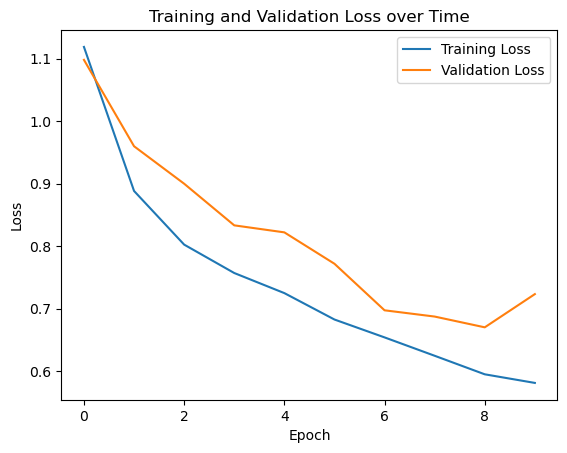

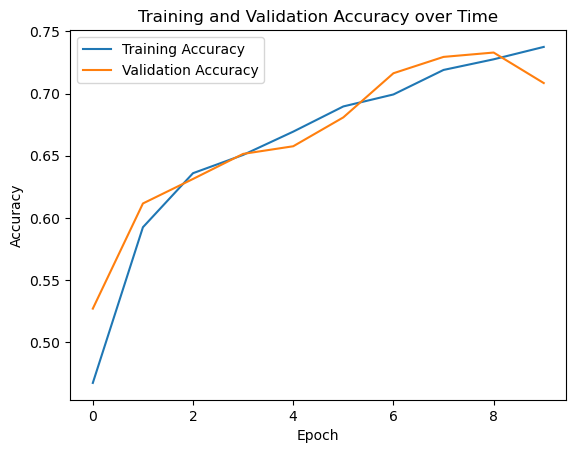

72/72 [==============================] - 6s 76ms/step


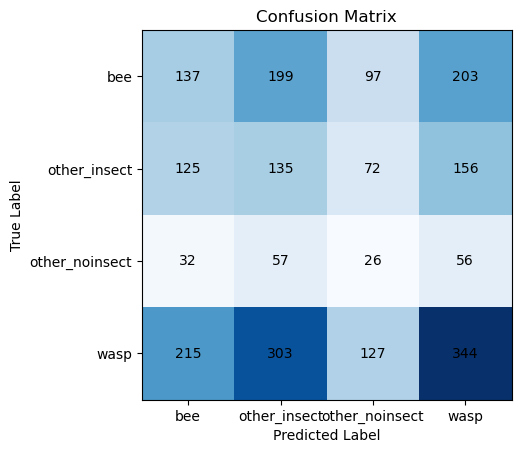

In [27]:
def evaluate_model(train_set, val_set, model, history, num_classes=4):
    '''Evaluates a model. 
          Takes in a train_set, val_set, model, history, number of classes.'''
    print("***********************************************************************")
    print("Evaluate the model:")
    print("***********************************************************************")
    # Evaluate the model
    loss, accuracy = model.evaluate(train_set)
    print(f'Test loss: {loss}')
    print(f'Test accuracy: {accuracy}')

    # Plot the training and validation loss over time
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot the training and validation accuracy over time
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    class_names = list(train_set.class_indices.keys()) # Get the class names
    
    y_pred = np.argmax(model.predict(val_set), axis=-1) # Make predictions on the test set

    num_val_samples = val_set.samples  # total number of validation samples
    batch_size = val_set.batch_size  # batch size

    # Calculate the number of batches
    num_batches = np.ceil(num_val_samples / batch_size)
    num_batches = int(num_batches)

    # Get the true labels
    y_true = np.concatenate([y for x, y in (next(val_set) for _ in range(num_batches))], axis=0)

    # Compute the confusion matrix
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred)
    
    # Plot the confusion matrix
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(range(num_classes),class_names)
    plt.yticks(range(num_classes), class_names)
    # plt.colorbar()
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
    plt.show()

evaluate_model(X_train, X_valid, model, history)

## 3. Class Weighting

The next method we will implement is adding class weighting. As Thakur & Gosthipaty write:
> One of the easiest ways to counter class imbalance is to use class weights wherein we give different weightage to different classes. The number of samples in the classes is considered while computing the class weights. We apply more significant weight to a minority class, which places more emphasis on that class. The classifier thus learns equally from both the classes. [Their example had only two classes]
>
> Class weights regularize the loss function. By misclassifying the minority class, a higher loss is incurred by the model since the minority class has a higher weight. This forces the model to learn representations for the minority class. This, however, comes at a price of slightly reduced performance for the majority class.

Note that they were dealing with two classes, here, we have four. Our code will handle datasets with different numbers of classes.



In [12]:
X_train, X_valid, cls_counts = load_display_data(data_path, 
                batch_size=32, shape=(80,80,3), show_pictures=False, 
                stratify=True, return_cls_counts=True)

***********************************************************************
Load data:
  - Loading the dataset from: /blue/practicum-ai/share/data/bee_vs_wasp.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
  - Stratify when sampling? True
  - Returning class counts to calculate wieghts? True
***********************************************************************

For the full dataset:
Number of wasp images: 4943, or 43.3%
Number of other_insect images: 2439, or 21.4%
Number of bee images: 3184, or 27.9%
Number of other_noinsect images: 856, or 7.5%
Found 9137 validated image filenames belonging to 4 classes.
Found 2284 validated image filenames belonging to 4 classes.

For the training dataset:
Number of wasp images: 3954, or 43.3%
Number of other_insect images: 1951, or 21.4%
Number of bee images: 2547, or 27.9%
Number of other_noinsect images: 685, or 7.5%

Class counts being returned: {'wasp': 4943, 'other_insect': 2439, 'bee': 3184, 'other_noinsect': 856}.


/apps/tensorflow/2.15/lib/python3.11/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


## 4. Make our model

This function creates the model we will use.

One hyperparameter to explore is the activation function, which is set when making the model. We start with a ReLU as the default, but you can try others. For simplicity, we will use the same activation function for all but the last layer of the model, but you could change them individually.

The last layer will almost always use a Softmax, which makes all the output values between 0 and 1 and sum to 1, transforming them into probabilities of the input belonging to each possible class.

In [35]:
def make_model(activation='relu', shape=(80,80,3), num_classes=4):
    '''Sets up a model. 
          Takes in an activation function, shape for the input images, and number of classes.
          Returns the model.'''
    print("***********************************************************************")
    print("Make model:")
    print(f"  - Using the activation function: {activation}.")
    print(f"  - Model will have {num_classes} classes.")
    print("***********************************************************************")
    
    # Define the model
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', activation=activation, input_shape=shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), padding='same', activation=activation),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        layers.Conv2D(128, (3, 3), padding='same', activation=activation),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation=activation),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

model = make_model()
model.summary()

***********************************************************************
Make model:
  - Using the activation function: relu.
  - Model will have 4 classes.
***********************************************************************
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 80, 80, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 40, 40, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 40, 40, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 20, 20, 64)        0         
 ng2D)                                                           
                        

## 5. Compile and Train the model

This step compiles the model, getting it ready for training. The primary hyperparameters here are:
* the **loss function** (how we determine how close the predicted output is from the known output values),
* the **optimization function** (how we determine what parameters should be updated and how),
* the **learning rate** (how much each parameter should be adjusted), 
* and how many **epochs** should be run (remember, an epoch is a full pass through all the training data). 

In [25]:
# Define a function that takes an optimizer name as a string
def load_optimizer(optimizer_name):
  # Check if the optimizer name is valid
  if optimizer_name in tf.keras.optimizers.__dict__:
    # Return the corresponding optimizer function
    return tf.keras.optimizers.__dict__[optimizer_name]
  else:
    # Raise an exception if the optimizer name is invalid
    raise ValueError(f"Invalid optimizer name: {optimizer_name}")

def compile_train_model(X_train, X_test, model,
                        loss='categorical_crossentropy',
                        optimizer='Adam', learning_rate=0.0001, epochs=10, cls_counts=False, log_name=None):
    '''Compiles and trains the model. 
          Takes in an X_train, X_test, model, loss function, optimizer, learning rate,
          epochs, if class weights should be used, and a list of callbacks.
          Returns the compiled model and training history.'''
    
    # Deal with class weights
    
    num_classes = len(list(X_train.class_indices.keys()))
    class_indices = range(num_classes)
    
    if not cls_counts:
        cls_wt = [1] * num_classes # Create a list of 1s as long as number of classes
        class_weights = dict(zip(class_indices, cls_wt))  
    
    else:
        # Calculate class weights to deal with imballance
        class_names = list(X_train.class_indices.keys())
        print(class_names)
        # Make a y from cls_counts
        y_vals = []
        for cls in list(X_train.class_indices.keys()):
            y_vals += [X_train.class_indices[cls]] * int(cls_counts[cls])

        cls_wt = class_weight.compute_class_weight('balanced', 
                                      classes=np.unique(y_vals), 
                                      y=y_vals)

        class_weights = dict(zip(class_indices, cls_wt))
     
    

    print("***********************************************************************")
    print("Compile and Train the model:")
    print(f"  - Using the loss function: {loss}.")
    print(f"  - Using the optimizer: {optimizer}.")
    print(f"  - Using learning rate of: {learning_rate}.")
    print(f"  - Running for {epochs} epochs.")
    print(f"   -Using class weights: {class_weights})")
    print("***********************************************************************")
    # Compile the model
    
    opt= load_optimizer(optimizer)(learning_rate=learning_rate)
    
    model.compile(optimizer=opt,
                  loss=loss,
                  metrics=['accuracy'])

    time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    log_dir = f"logs/fit_weights_{log_name}_{epochs}_{time}"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


    # Train the model
    history = model.fit(X_train, epochs=epochs, validation_data=X_test, class_weight=class_weights, callbacks=[tensorboard_callback])
    
    return model, history

model, history = compile_train_model(X_train, X_valid, model, cls_counts=cls_counts, log_name='weights')

['bee', 'other_insect', 'other_noinsect', 'wasp']
***********************************************************************
Compile and Train the model:
  - Using the loss function: categorical_crossentropy.
  - Using the optimizer: Adam.
  - Using learning rate of: 0.0001.
  - Running for 10 epochs.
   -Using class weights: {0: 0.8968278894472361, 1: 1.1707667076670767, 2: 3.3358644859813085, 3: 0.5776856160226583})
***********************************************************************
Epoch 1/10
286/286 [==============================] - 68s 236ms/step - loss: 1.1188 - accuracy: 0.4674 - val_loss: 1.0981 - val_accuracy: 0.5271
Epoch 2/10
286/286 [==============================] - 68s 237ms/step - loss: 0.8882 - accuracy: 0.5925 - val_loss: 0.9598 - val_accuracy: 0.6116
Epoch 3/10
286/286 [==============================] - 67s 236ms/step - loss: 0.8023 - accuracy: 0.6360 - val_loss: 0.8998 - val_accuracy: 0.6313
Epoch 4/10
286/286 [==============================] - 69s 239ms/step - los

## 6. Evaluate the model

Now that we have trained our model let's evaluate how it does.


***********************************************************************
Evaluate the model:
***********************************************************************
72/72 [==============================] - 6s 77ms/step - loss: 0.7231 - accuracy: 0.7084
Test loss: 0.7230812311172485
Test accuracy: 0.7084063291549683


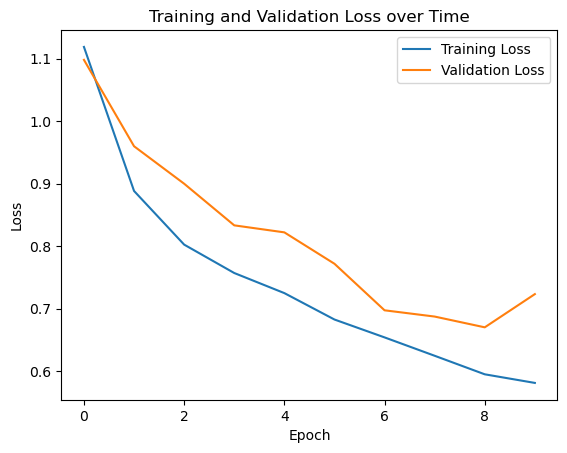

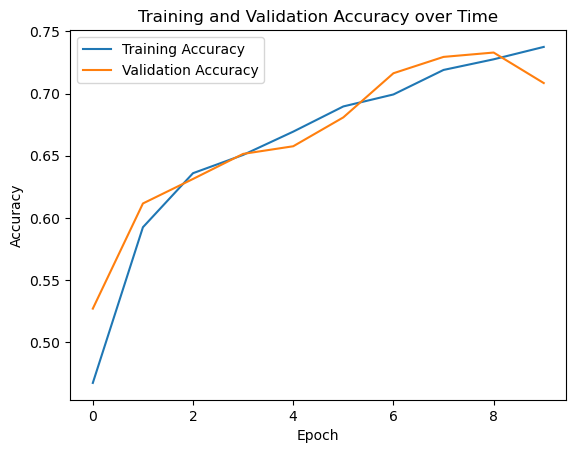

AttributeError: 'DataFrameIterator' object has no attribute 'class_names'

In [26]:
helpers_01.evaluate_model(X_train, X_valid, model, history)

Some improvement, but not a silver bullet!

## 7. Over and Undersampling

Another option outlined in the Thakur & Gosthipaty article is to over or undersample the data. In oversampling, we keep the same number of the majority class, wasps in our case, and resample the other classes duplicating images to reach the same number. Importantly, as noted but Thakur & Gosthipaty:

> With this technique, it is essential to note that we are artificially reducing the dataset's variance. The resulting model might do poorly upon data shift or data corruption.

Alternatively, with undersampling, we limit the number of images per class to the number in the class with the fewest images, other non-insects in our case. 

Below is the relevant code of our existing data loader in the [helpers_01.py](helpers_01.py) file:

'''python
 # Load the dataset
    X_train = tf.keras.preprocessing.image_dataset_from_directory(
        directory_path,
        batch_size=batch_size,
        image_size=image_size,
        validation_split=0.2,
        subset='training',
        seed=123,
        labels='inferred',
        label_mode='int'
    )
    
    X_test = tf.keras.preprocessing.image_dataset_from_directory(
        directory_path,
        batch_size=batch_size,
        image_size=image_size,
        validation_split=0.2,
        subset='validation',
        seed=123,
        labels='inferred',
        label_mode='int'
    )
'''

To change this, we will use the `tf.Data.sample_from_datasets function` (note that the `tf.experimental.sample_from_datasets` function suggested by Thakur & Gosthipaty is depricated).

sample_from_datasets(
    datasets,
    weights=None,
    seed=None,
    stop_on_empty_dataset=False,
    rerandomize_each_iteration=None
)

In [53]:
# Check our data path
print(f'Data are at: {data_path}, with folders named {sorted(os.listdir(data_path))}')

datasets=[]
for folder in sorted(os.listdir(data_path)):
    datasets.append(os.path.join(data_path, folder))
   
print(f'The datasets list is now: {datasets}')

# Set batch size and image size
batch_size=32
image_size=[80,80]

# Create X_train and X_test for each catergory
X_train={}
X_valid={}

folder_count=0 # set for labels
for folder in sorted(os.listdir(data_path)):
    
    # Get the list of images in the class
    images = os.listdir(os.path.join(data_path, folder))
    # Append the number of images in the class to the list
    num_images=(len(images))
    
    labels=[folder_count] * num_images
    
    X_train[folder_count] = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(data_path, folder),
        batch_size=batch_size,
        image_size=image_size,
        validation_split=0.2,
        subset='training',
        seed=123,
        labels=labels,
        label_mode='int'
    )
    
    X_valid[folder_count] = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(data_path, folder),
        batch_size=batch_size,
        image_size=image_size,
        validation_split=0.2,
        subset='validation',
        seed=123,
        labels=labels,
        label_mode='int'
    )
    
    # We don't need to resample the validation dataset
    # So, concatinate them as we go after the 1st one
    if folder_count == 1:
        X_valid_combined = X_valid[0].concatenate(X_valid[1])
    elif folder_count > 1:
        X_valid_combined = X_valid_combined.concatenate(X_valid[folder_count])
        
    folder_count+=1



# Make the resampled dataset
X_train_resampled = tf.data.Dataset.sample_from_datasets(list(X_train.values()),
                stop_on_empty_dataset=True,
                rerandomize_each_iteration=True
)





Data are at: /blue/practicum-ai/share/data/bee_vs_wasp, with folders named ['bee', 'other_insect', 'other_noinsect', 'wasp']
The datasets list is now: ['/blue/practicum-ai/share/data/bee_vs_wasp/bee', '/blue/practicum-ai/share/data/bee_vs_wasp/other_insect', '/blue/practicum-ai/share/data/bee_vs_wasp/other_noinsect', '/blue/practicum-ai/share/data/bee_vs_wasp/wasp']
Found 3184 files belonging to 1 classes.
Using 2548 files for training.
Found 3184 files belonging to 1 classes.
Using 636 files for validation.
Found 2439 files belonging to 1 classes.
Using 1952 files for training.
Found 2439 files belonging to 1 classes.
Using 487 files for validation.
Found 856 files belonging to 1 classes.
Using 685 files for training.
Found 856 files belonging to 1 classes.
Using 171 files for validation.
Found 4943 files belonging to 1 classes.
Using 3955 files for training.
Found 4943 files belonging to 1 classes.
Using 988 files for validation.


In [54]:
model, history = compile_train_model(X_train_resampled, X_valid_combined, model,  cls_counts=cls_counts, log_name='oversample')

AttributeError: '_DirectedInterleaveDataset' object has no attribute 'class_names'

In [57]:
 model.compile(optimizer='Adam',
                  loss=SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
epochs = 10
learning_rate = 0.001
log_name = 'oversample'

time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

log_dir = f"logs/fit_weights_{log_name}_{epochs}_{time}"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


# Train the model
history = model.fit(X_train_resampled, epochs=epochs, steps_per_epoch=286, validation_data=X_valid_combined, callbacks=[tensorboard_callback])

Epoch 1/10
286/286 [==============================] - 25s 84ms/step - loss: 1.3898 - accuracy: 0.2217 - val_loss: 1.3936 - val_accuracy: 0.0749
